<a href="https://colab.research.google.com/github/Zoldycklml/DeepLearning-2022B-T6/blob/main/CNN_Arrythmia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Implementación en PyTorch** [5]

De nuevo utilizaremos un conjunto de imágenes de la base de datos MNIST para crear un modelo clasificador. Primero importamos las librerías necesarias y se verifica la funcionalidad de la GPU.

In [1]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
import datetime, os
import random
from torch.nn.functional import normalize
random.seed(10)

In [2]:
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 161 kB 7.5 MB/s 


In [3]:
import wfdb

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [7]:
#Descargar el dataset
wfdb.dl_database("mitdb","/content/gdrive/MyDrive/CNN_DATA/Dataset")

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [5]:
#data = wfdb.rdrecord(record_name=f"/content/gdrive/MyDrive/CNN_DATA/Dataset/100")
#Genero una lista de los elementos del dataset
records= wfdb.get_record_list("mitdb")
for record in records:
 if record == '102' or record == '104' or record == '107' or record ==  '217': #omitiendo las señales con marcapasos
  records.remove(record)
#La visualizo
print(records)
print(len(records))

['100', '101', '103', '105', '106', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']
44


['+', 'N'] [28  1]


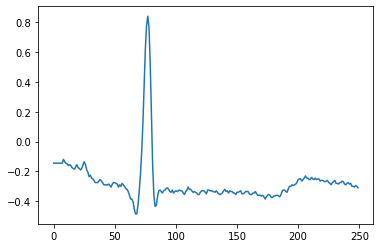

In [6]:
#Visualizamos una muestra de los datos:
  #obtenemos una grabacion de la muestra 0 a 250 (aproximadamente un qrs)
recordsig = wfdb.rdrecord("/content/gdrive/MyDrive/CNN_DATA/Dataset/100", sampto=250, channels=[0])
recordann = wfdb.rdann("/content/gdrive/MyDrive/CNN_DATA/Dataset/100","atr", sampto=250,return_label_elements=['symbol', 'label_store'])

  #convertimos a matriz numpy
muestra_1 = recordsig.p_signal
simbolo=recordann.symbol
etiqueta=recordann.label_store #trabajaremos con este


  #Podemos visualizar la muestra en matriz:
print(simbolo, etiqueta)


  #Podemos visualizar la muestra graficamente con matplot
%matplotlib inline 
plt.plot(muestra_1)
#plt.savefig('fig1.png')#con este comando podemos guardar esa imagen

Hay que recordar lo que physionet declara que significan los simbolos de sus anotaciones:

1 = 'N' = Normal beat

Otros = Arritmia

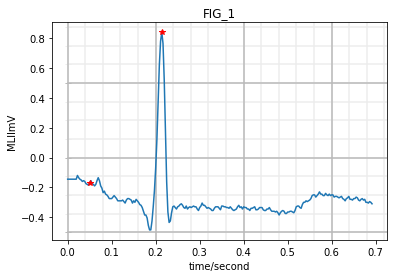

In [7]:
#Incluso podemos generar una imagen en la cual visualizar la etiqueta en el complejo dado:
wfdb.plot_wfdb(recordsig,recordann, time_units='seconds',title='FIG_1',ecg_grids='all')

In [67]:
#ahora voy a sacar un vector correspondiente a 1 complejo pqrst
#un loop que itere los elementos y obtenda un vector cada 250 muestras y los almacene en una matriz
cont=0
#hacemos listas vacias para almacenar nuestros datos
muestras_lista=[]
etiquetas_lista=[]

for record in records:
  for i in range(0, 171000*2, 750):#con una muestra cada 750 datos para tener aprox 10k datos
   recordsig=wfdb.rdrecord(f"/content/gdrive/MyDrive/CNN_DATA/Dataset/{record}",sampfrom=i, sampto=i+750, channels=[0])
   recordann=wfdb.rdann(f"/content/gdrive/MyDrive/CNN_DATA/Dataset/{record}","atr",sampfrom=i, sampto=i+750, return_label_elements=['label_store'])

   etiquetas_lista.append(recordann.label_store) #trabajaremos con los numeros de las etiquetas y no con su caracter asociado
  
   muestras_lista.append(recordsig.p_signal)#Estas de momento las dejaremos como numpy arrays
   muestras_lista[cont]=muestras_lista[cont].squeeze()#Eliminamos la dimension vacia extra que nos dan
   #print(muestras_lista[i].shape)

   cont=cont+1 #para saber cuantas muestras se han generado
   print(cont)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
15065
15066
15067
15068
15069
15070
15071
15072
15073
15074
15075
15076
15077
15078
15079
15080
15081
15082
15083
15084
15085
15086
15087
15088
15089
15090
15091
15092
15093
15094
15095
15096
15097
15098
15099
15100
15101
15102
15103
15104
15105
15106
15107
15108
15109
15110
15111
15112
15113
15114
15115
15116
15117
15118
15119
15120
15121
15122
15123
15124
15125
15126
15127
15128
15129
15130
15131
15132
15133
15134
15135
15136
15137
15138
15139
15140
15141
15142
15143
15144
15145
15146
15147
15148
15149
15150
15151
15152
15153
15154
15155
15156
15157
15158
15159
15160
15161
15162
15163
15164
15165
15166
15167
15168
15169
15170
15171
15172
15173
15174
15175
15176
15177
15178
15179
15180
15181
15182
15183
15184
15185
15186
15187
15188
15189
15190
15191
15192
15193
15194
15195
15196
15197
15198
15199
15200
15201
15202
15203
15204
15205
15206
15207
15208
15209
15210
15211
15212
15213
15214
15215
15216
15217
15218
15219
152

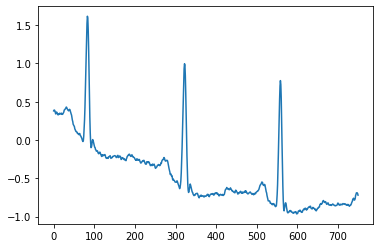

In [68]:
plt.plot(muestras_lista[20000]) #Mostrando una de las imagenes

In [69]:
def NormalizeData(data): #funcion para normalizar
    #return (data - np.min(data)) / (np.max(data) - np.min(data))
    result = (data - np.min(data))/np.ptp(data)
    return result

<class 'torch.Tensor'>
<class 'torch.Tensor'>


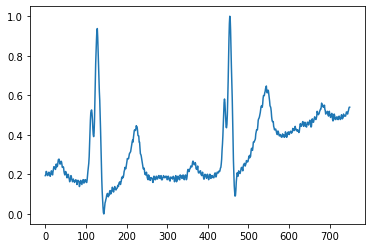

In [70]:
#Normalizamos los datos:
for i in range(len(muestras_lista)):
  muestras_lista[i]=NormalizeData(muestras_lista[i])


#Necesitaremos que sean tensores float
muestras_lista = [torch.from_numpy(item).float() for item in muestras_lista]
etiquetas_lista = [torch.from_numpy(item).float() for item in etiquetas_lista]
plt.plot(muestras_lista[3343].numpy()) #podemos ver los datos ya normalizados

#Confirmamos que el datatype sea tensor:
print(type(etiquetas_lista[0]))
print(type(muestras_lista[0]))


In [71]:
print(etiquetas_lista[:5]) #podemos visualizar las etiquetas que tenemos generadas
#print(muestras_lista[:1])

[tensor([28.,  1.,  1.,  1.]), tensor([1., 1.]), tensor([1., 1., 8.]), tensor([1., 1., 1.]), tensor([1., 1.])]


In [72]:
#Ahora necesitamos aclarar bien que etiqueta debera recibir la red, en este caso particular solo queremos que nos diga si el complejo
#analizado tiene o no arritmia, por lo que a nuestra lista que almacena la etiqueta la pondremos a 1 si para indicar que si hay arrtimia
#y a 0 para indicar que no
for i in range(10032*2):
  if 1 in etiquetas_lista[i]: #recordemos que 28 es el indicador de un ritmo desincronizado
    etiquetas_lista[i]=0
  else:
    etiquetas_lista[i]=1


In [73]:
#Vamos a ver que proporcion tenemos en los datos
dict(zip(etiquetas_lista,map(lambda x: etiquetas_lista.count(x),etiquetas_lista)))
#Esto nos mostrara un diccionario donde nos dira en cuantos datos hay arritmia y en cuantos  no (recordando que 1 es para arritmia y 0 para no arritmia)

{0: 16093, 1: 3971}

In [20]:
#Ahora vamos a dividir los datos que usaremos para entrenar y los que usaremos para testear
#Usaremos una proporcion 20/80 (20% test y 80% entrenamiento)
#train_length=153

#ecg_train=muestras_lista[0: train_length]
#ecg_test=muestras_lista[train_length:]

#No olvidemos las etiquetas
#ecg_train_label=etiquetas_lista[0: train_length]
#ecg_test_label=muestras_lista[train_length:]

In [74]:
#Metemos los datos a un dataframe, para que sea mas entendible, haremos 2 dataframes, uno para los 
#Datos de entrenamiento y otro para los datos de testing
DATAF_Test= pd.DataFrame(columns=['señal','etiqueta'])
for i in range(2000*2): # 20% del total
  DATAF_Test=DATAF_Test.append({'señal': muestras_lista[i], 'etiqueta':etiquetas_lista[i]}, ignore_index=True)
  #print(DATAF_Test)   #Con esto visualizariamos la creacion del dataframe

DATAF_Train= pd.DataFrame(columns=['señal','etiqueta'])
for i in range(2000*2, 10000*2): #80% del total
  DATAF_Train=DATAF_Train.append({'señal': muestras_lista[i], 'etiqueta':etiquetas_lista[i]}, ignore_index=True)
  #print(DATAF_Train)  #Con esto visualizariamos la creacion del dataframe

In [ ]:
#Lo podemos exportar a  un CSV
DATAF_Test.to_csv('/content/gdrive/MyDrive/CNN_DATA/ARRITMIA_DATA_Test.csv', index=False)
DATAF_Train.to_csv('/content/gdrive/MyDrive/CNN_DATA/ARRITMIA_DATA_Train.csv', index=False)

In [75]:
#Hacemos una clase que tenga metodos "len" y "getitem" los cuales son solicitados mas adelante
class ProcessDataFrame(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.x = self.dataset['señal'].values
        self.y = self.dataset['etiqueta'].values
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [76]:
#Creamos objetos para train y test de la clase para procesar

Data_Test=ProcessDataFrame(DATAF_Test)
Data_Train=ProcessDataFrame(DATAF_Train)


In [77]:
#Usamos dataloader de torch para alistar los datos para la red
#Es aqui donde se requiere que los datos entregados sean un objeto con los atributos mencionados (len y getitem)
loaders = {
    'train' : torch.utils.data.DataLoader(Data_Train, 
                                          batch_size=16, 
                                          shuffle=True, 
                                          num_workers=1), 
    'test'  : torch.utils.data.DataLoader(Data_Test, 
                                          batch_size=16, 
                                          shuffle=True, 
                                          num_workers=1)}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f4fdb50fc10>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f4fdb56c450>}

In [78]:
#Checamos el tamaño de cada loader, es importante que sea divisible entre 5, el batchsize que usamos
print(len(loaders['test']))
print(len(loaders['train']))

250
1000


## 2) Construcción del modelo

In [79]:
# Definir "semilla" para garantizar reproductibilidad
SEED = 1111
#random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [80]:
from torch.nn.modules.activation import ReLU
'''# Modelo CNN piratiado
class CNN(nn.Module):
      def __init__(self):
          super(CNN, self).__init__()        
          self.conv1 = nn.Sequential(      #PRimer capa convolucional   
              nn.Conv1d(in_channels=1,out_channels=200,kernel_size=1),nn.ReLU(),nn.MaxPool1d(1))
          self.conv2 = nn.Sequential(      #segunda capa convolucional
              nn.Conv1d(in_channels=200,out_channels=1, kernel_size=1),nn.ReLU(), nn.Linear(750,10, True), nn.ReLU())
          self.fc = nn.Linear(10, 1, True)
              
      def forward(self, x):
          x = self.conv1(x)
          #print(x.size())
          x = self.conv2(x)
         # print(x.size())
          x = self.fc(x)
          #print(x.size())
          #print(torch.Tensor.size(x.squeeze()))
          return x.view(16)   # return x for visualization #output[:,0]'''

class CNN(torch.nn.Module):
	def __init__(self):
		super().__init__()
		self.model = torch.nn.Sequential(
			torch.nn.Conv1d(in_channels = 1, out_channels = 32, kernel_size = 1, padding = 1),
			torch.nn.ReLU(),
			torch.nn.Conv1d(in_channels = 32, out_channels = 1, kernel_size = 1, padding = 1),
			torch.nn.ReLU(),

			torch.nn.Flatten(),
			torch.nn.Linear(754, 512),
			torch.nn.ReLU(),
			torch.nn.Linear(512, 1),
      torch.nn.Sigmoid(),
      torch.nn.Linear(1, 1),
      torch.nn.Dropout()
		)

	def forward(self, x):
		return self.model(x).view(16)

In [81]:
cnn = CNN() #"materializamos" el modelo
print(cnn)

CNN(
  (model): Sequential(
    (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 1, kernel_size=(1,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=754, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=1, bias=True)
    (8): Sigmoid()
    (9): Linear(in_features=1, out_features=1, bias=True)
    (10): Dropout(p=0.5, inplace=False)
  )
)


In [ ]:
# Función de costo
criterion = nn.BCELoss()
# Función de optimización
optimizer = optim.Adam(cnn.parameters(), lr = 0.5)

## 3) Entrenamiento del modelo

Epoch 1/10: Training loss = 50.45
Epoch 2/10: Training loss = 50.34375
Epoch 3/10: Training loss = 50.39375
Epoch 4/10: Training loss = 50.81875
Epoch 5/10: Training loss = 50.00625
Epoch 6/10: Training loss = 49.9375
Epoch 7/10: Training loss = 49.65
Epoch 8/10: Training loss = 49.83125
Epoch 9/10: Training loss = 49.775
Epoch 10/10: Training loss = 49.85625


Text(0, 0.5, 'Training loss')

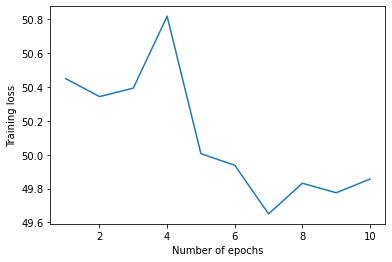

In [88]:
num_epochs = 10
train_loss_list = []
for epoch in range(num_epochs):
 print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
 train_loss = 0
 #Iterating over the training dataset in batches
 cnn.train(True)
 for i, (señal, etiqueta) in enumerate(loaders['train']):
  #Calculating the model output and the cross entropy loss
  señal=señal.view(16,1,750) #acomodamos los datos de muestra para que sean congruentes a batch, 1 channel y 250 longitud de señal
  outputs = cnn(señal)
  for i in range(16): #Definiendo el rango, resultado negativo sera 0 y positivo sera 1
    if outputs[i] < 0:
      outputs[i]=0
    else:
      outputs[i]=1
  #print(outputs)
  #señal= Variable(señal)
  #etiqueta= Variable(etiqueta)
  loss = criterion(outputs, etiqueta.float())
  #Updating weights according to calculated loss
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  train_loss += loss.item()
	
 #Printing loss for each epoch
 train_loss_list.append(train_loss/len(loaders['train']))
 print(f"Training loss = {train_loss_list[-1]}")
	
#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), train_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")


## 4) Prueba del modelo

In [89]:
# Visualización de resultados
writer = SummaryWriter()

for n_iter in range(25):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)

In [90]:
# Evaluación

def test():
    # Test the model
    cnn.eval()    
    with torch.no_grad():
        correct = 0
        total = 0
        for señal, etiqueta in loaders['test']:
            #print(señal.size())
            señal=señal.view(16,1,750)
            test_output = cnn(señal)
            #print(señal)
            for i in range(16): #Definiendo el rango, resultado negativo sera 0 y positivo sera 1
             if test_output[i] < 0:
                test_output[i]=0
             else:
              test_output[i]=1
            pred_y = test_output
            #print(pred_y)
            accuracy = (pred_y == etiqueta).sum().item() / float(etiqueta.size(0))
            pass

    print('Test Accuracy of the model on the 2000 samples: %.4f' % accuracy)
    
    pass
test()

Test Accuracy of the model on the 2000 samples: 0.8125


# **2. Referencias**
[1] Ketkar, N., & Moolayil, J. (2021). Deep learning with Python: learn best practices of deep learning models with PyTorch. Apress.


[2] Amidi, A., & Amidi, S. (2019). CS 230 - Convolutional Neural Networks Cheatsheet. CS 230 - Deep Learning, Stanford University. Recuperado 13 de junio de 2022, de https://stanford.edu/%7Eshervine/teaching/cs-230/cheatsheet-convolutional-neural-networks

[3] Thoma, M. (2017). Analysis and Optimization of Convolutional Neural Network Architectures. University of the State of Baden-Wuerttemberg and National Research Center of the Helmholtz Association.

[4] Saha, S. (2021, 7 diciembre). A Comprehensive Guide to Convolutional Neural Networks — the ELI5 way. Medium. Recuperado 13 de junio de 2022, de https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

[5] N. (2022, 6 enero). PyTorch Convolutional Neural Network With MNIST Dataset. Medium. Recuperado 13 de junio de 2022, de https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118

[6] Xie, B., Zhang, H. K., & Xue, J. (2019). Deep convolutional neural network for mapping smallholder agriculture using high spatial resolution satellite image. Sensors, 19(10), 2398.

[7] Du, S. (2021, 13 diciembre). Understanding Deep Self-attention Mechanism in Convolution Neural Networks. Medium. Recuperado 13 de julio de 2022, de https://medium.com/ai-salon/understanding-deep-self-attention-mechanism-in-convolution-neural-networks-e8f9c01cb251

[8] Alom, M. Z., Taha, T. M., Yakopcic, C., Westberg, S., Sidike, P., Nasrin, M. S., ... & Asari, V. K. (2019). A state-of-the-art survey on deep learning theory and architectures. Electronics, 8(3), 292.

[9] Chapter 5: Introduction to Convolutional Neural Networks. (s. f.). Recuperado 23 de septiembre de 2022, de https://www.tomasbeuzen.com/deep-learning-with-pytorch/chapters/chapter5_cnns-pt1.html

[10] Shafkat, I. (2018, 21 junio). Intuitively Understanding Convolutions for Deep Learning. Medium. Recuperado 23 de septiembre de 2022, de https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1